<h1 style="font-size:2.0em; font-weight:bold; text-align:center;">Feature Engineering </h1>



The dataset spans from **April 2, 2025** to **April 4, 2025**, based on the assumption that mid-2025 trade tensions lead to an increase in abnormal or suspicious transaction activities.

For **Feature Engineering**, we handled numerical and categorical variables separately with the following steps: 

- Handle missing values.

- Create new features.

- Apply feature transformations.



In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 
import plotly.express as px
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv('data/EDA_transaction_monitoring_merged.csv')

In [4]:
df.head().T

,0,1,2,3,4
customer_id,CUST00537,CUST00932,CUST00322,CUST00936,CUST00235
transaction_id,0e6bbde0-ed0d-4017-ab10-a823d7770933,56a701ab-a66c-4f43-83f3-8f4efaf36aec,658a8377-3da8-437a-9e69-d7ef08b3c111,c69e17c9-6018-4b17-bec5-715ca71db3a6,71f34593-a737-419b-a1e0-9bf146748ee4
currency,EUR,EUR,NOK,DKK,EUR
transaction_date,2025-04-28 03:14:28,2025-06-18 13:49:07,2025-05-15 04:56:33,2025-05-30 18:15:41,2025-04-14 03:55:35
value_date,2025-04-28 03:14:28,2025-06-19 13:49:07,2025-05-17 04:56:33,2025-05-30 18:15:41,2025-04-16 03:55:35
...,...,...,...,...,...
dob_weekday,1,0,6,1,1
last_transaction_date_day,29,1,14,23,29
last_transaction_date_month,6,7,6,6,6
last_transaction_date_weekday,6,1,5,0,6


## <h2 style="font-size: 1.8em; font-weight: bold;"> Feature Engineering </h2>

## <h3 style="font-size: 1.6em; font-weight: bold;"> 1. Handling Missing Values </h2>

In [6]:
#First, start with categorical features.
feature_na = [feature for feature in df.columns 
              if df[feature].isnull().sum()>1]
feature_na

['message', 'own_message', 'card_number']

As discovered in the EDA, most of the columns with missing values are categorical, so we will replace them with a new label, 'missing'.

In [ ]:
#Drop or fill with 0 for columns that show no meaningful correlation with the target variable.
for feature in feature_na: 
  df[feature_na] = df[feature_na].fillna ('missing') 

customer_id                      0
transaction_id                   0
currency                         0
transaction_date                 0
value_date                       0
                                ..
dob_weekday                      0
last_transaction_date_day        0
last_transaction_date_month      0
last_transaction_date_weekday    0
age                              0
Length: 62, dtype: int64

In [9]:
df.isnull().sum().unique()

array([0], dtype=int64)

In this project, there are no missing numeric values. But if there were, we’d use the median or mode to fill them in, since we found outliers during EDA.

## <h2 style="font-size: 1.6em; font-weight: bold;"> 2. New Features Creation </h2>

**Numeric Features**

`turnover_jump_pct`

Calculate the Turnover Jump % to spot any unusual spikes in transaction volumes that could indicate suspicious activity.

In [ ]:
df['turnover_jump_pct'] = (100.00* df['amount_eur']/ df['expected_turnover']).round(2)
len(df.loc[df['turnover_jump_pct'] > 100.00])

407

We found 407 transactions with a turnover jump percentage over 100%.

`risky_flag`

Flag all transactions sent to risky countries (as defined by sanctions and potential tariff threats)

In [7]:
risky_countries = ['HK', 'SG', 'CN', 'RU']

df['is_rirsk _country'] = df['counterparty_country'].isin(risky_countries).astype(int)

count_countries_flag = (df['is_rirsk _country'] == 1).sum()
count_countries_flag

3010

We found 3,010 transactions sent to risky countries.

`split_payment`

To flag `split_payment`, we applied business rules to identify accounts that show any of these signs:

- Made multiple payments within a single day.

- Had repeated or similar transaction amounts

- Made more than a set number of payments (high frequency).

In [8]:
# Case 1: Made multiple payments within a single day
df['transaction_date'] = pd.to_datetime(df['transaction_date'])
time_diff = df.groupby('from_account_name')['transaction_date'].diff()
df['is_sequential']= (time_diff <= pd.Timedelta(days=1)).astype(int)

# Case 2: Had repeated or similar transaction amounts
df['is_repeated_amount'] = df.groupby('from_account_name')['amount_eur'].transform(
    lambda x: x.duplicated(keep=False)
).astype(int)

# Case 3: Made more than 3 payments (high frequency)
txn_count = df.groupby('from_account_name')['transaction_id'].transform('count')
df['is_high_frequency'] = (txn_count >= 3).astype(int)

# Final flag: if any condition is met
df['is_split'] = (df['is_sequential'] | df['is_repeated_amount'] | df['is_high_frequency']
)

count_split_payment = (df['is_split'] ==1).sum()
count_split_payment

1395

We have 1,395 transactions marked as split payments.

## <h2 style="font-size: 1.6em; font-weight: bold;"> 3. Feature Transformation </h2>

**3.1 Continuous Variable**

In [ ]:
continuous_feature = df.select_dtypes(include='float').columns.to_list()
print(continuous_feature)

['amount', 'expected_turnover', 'amount_eur', 'turnover_jump_pct']


As discovered during EDA, most numerical variables are skewed and require transformation.

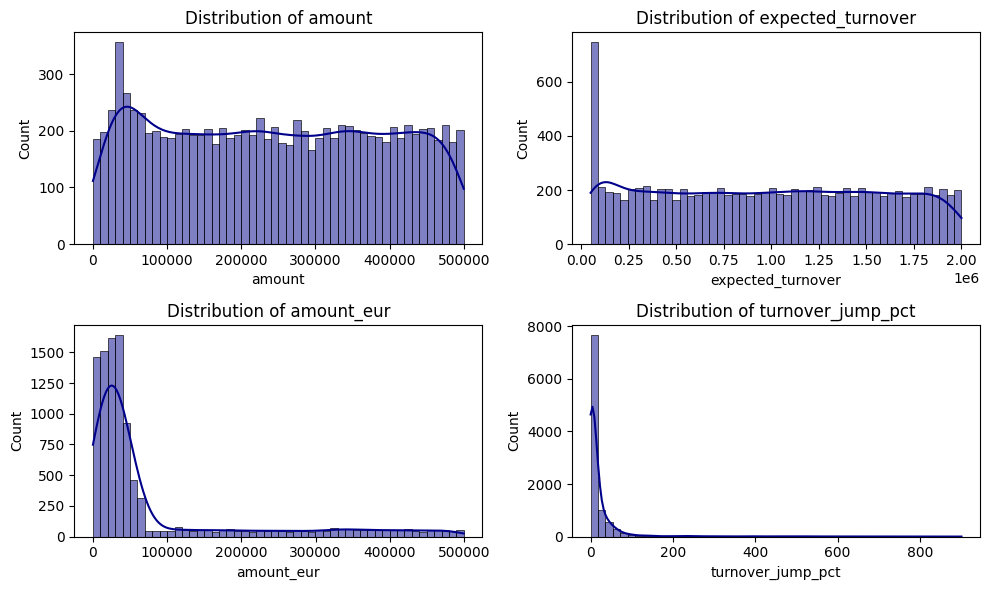

In [10]:
plt.figure(figsize=(10, 6))
for i, col in enumerate(continuous_feature,1):
      df_copy = df.copy()
      plt.subplot(2, 2, i)
      sns.histplot(df_copy[col], bins=50, kde=True, color='darkblue')
      plt.title(f'Distribution of {col}')
      plt.xlabel(col)
      plt.ylabel('Count')

plt.tight_layout()
plt.show()

Let's apply log transformation.

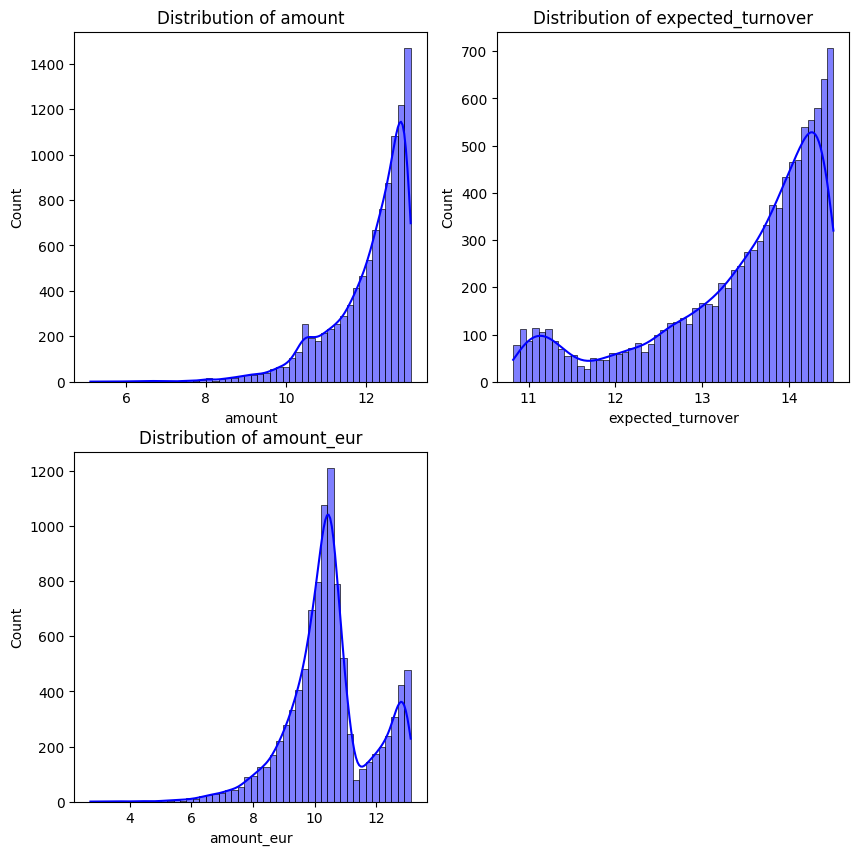

In [11]:

from numpy import log

plt.figure(figsize=(10, 10))
for i, col in enumerate(continuous_feature,1):
    df_copy=df.copy()
    if 0 in df_copy[col].unique():
        pass
    else:
       df_copy[col] = np.log(df_copy[col])
       plt.subplot(2, 2, i)
       sns.histplot(df_copy[col], bins=50, kde=True, color='blue')
       plt.title(f'Distribution of {col}')
       plt.xlabel(col)
       plt.ylabel('Count')

 

The results have improved slightly, but not significantly. Let's try applying the Box-Cox transformation again.

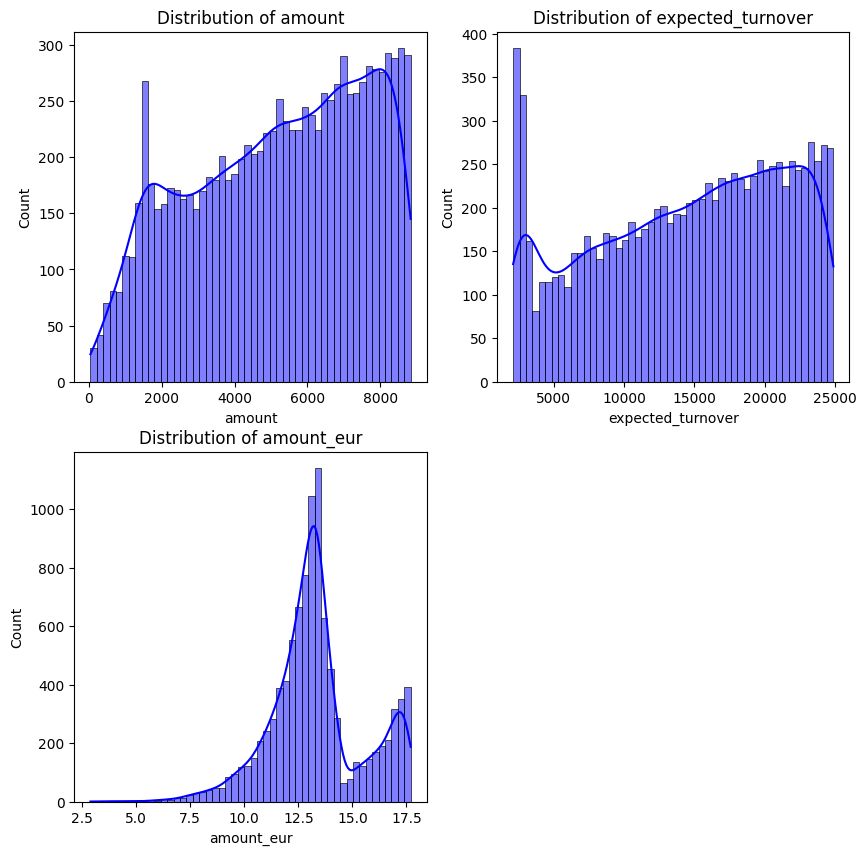

In [12]:
from scipy.stats import boxcox

plt.figure(figsize=(10, 10))
for i, col in enumerate(continuous_feature,1):
    if 0 in df[col].unique():
        pass
    else:
       bc_result,_ = boxcox(df[col])
       plt.subplot(2, 2, i)
       sns.histplot(bc_result, bins=50, kde=True, color='blue')
       plt.title(f'Distribution of {col}')
       plt.xlabel(col)
       plt.ylabel('Count')

It seems Box-Cox performs better than log transformation.

**3.2 Categorical Feature**

In [13]:
df['transaction_date'] = df['transaction_date'].astype(str)
categorical_feature = df.select_dtypes(include='object').columns.to_list()

#Identify the number of unique categories in each categorical (object) column.
for feature in categorical_feature: 
    count_value = df[feature].value_counts()
    print (feature,'-', len(count_value),'categories')


transaction_id - 10116 categories
transaction_date - 273 categories
booking_date - 275 categories
value_date - 276 categories
payment_date - 279 categories
currency - 5 categories
from_account_id - 10116 categories
from_account_name - 8776 categories
counterparty_account_id - 10116 categories
counterparty_name - 8378 categories
counterparty_country - 10 categories
counterparty_bank_bic - 4 categories
counterparty_business_type - 5 categories
narrative - 8826 categories
payment_purpose_code - 5 categories
related_trade_invoice_id - 2880 categories
swift_message_type - 3 categories
transaction_status - 3 categories
transaction_type_description - 4 categories
end_to_end_identification - 5324 categories
from_account_country - 4 categories
from_account_business_type - 6 categories


In [14]:
drop_col = []
date_col = ['transaction_date', 'booking_date', 'value_date', 'payment_date']
for feature in categorical_feature: 
    count_value = df[feature].value_counts() 
    if len(count_value) == len(df):
      drop_col.append(feature)
    if feature in date_col:
      drop_col.append(feature)
print(drop_col)

['transaction_id', 'transaction_date', 'booking_date', 'value_date', 'payment_date', 'from_account_id', 'counterparty_account_id']


In [15]:
categorical_feature = [col for col in categorical_feature if col not in drop_col]

*Rare Categorical Feature*

We will lable 'rare_var' for categorical variables that appear in less than 1% of the observations, as they carry little significance for the analysis.

In [16]:
for feature in categorical_feature:
      counts = df[feature].value_counts()
      rare_categories = counts[counts < len(df) * 0.01].index
      df[feature] = df[feature].apply(lambda x: 'rare_var' if x in rare_categories else x)

In [17]:
df[categorical_feature].nunique()

currency                         5
from_account_name                1
counterparty_name                2
counterparty_country            10
counterparty_bank_bic            4
counterparty_business_type       5
narrative                        4
payment_purpose_code             5
related_trade_invoice_id         2
swift_message_type               3
transaction_status               3
transaction_type_description     4
end_to_end_identification        2
from_account_country             4
from_account_business_type       6
dtype: int64

In [18]:
#high_card_feature = []
#for feature in categorical_features: 
    #if feature not in drop_col:
     #count_value = categorical_features[feature].value_counts()
     #if len(count_value) > 10:
       #high_card_feature.append(feature)


In [19]:
##for feature in high_card_feature:
      #labels_ordered = df.groupby([feature])['is_fraud'].mean().sort_values().index
      #labels_ordered = {k: i for i, k in enumerate(labels_ordered, 0)}
      #df[feature] = df[feature].map(labels_ordered)
#df[high_card_feature].nunique()

In [20]:
#from sklearn.model_selection import KFold

#from sklearn.model_selection import KFold

#kf = KFold(n_splits=5, shuffle=True, random_state=42)

#for feature in high_card_feature:
    #if feature not in drop_col:
        #df[feature] = np.nan  # clear column to store encoded values

        #for train_idx, val_idx in kf.split(df):
            #means = df.iloc[train_idx].groupby(feature)['is_fraud'].mean()
            #df.loc[df.index[val_idx], feature] = df.loc[df.index[val_idx], feature].map(means)

        #df[feature].fillna(df['is_fraud'].mean(), inplace=True)

#df[high_card_feature].nunique()


In [21]:
#Collect high-cardinality features that have no relationship with is_fraud into a drop list
#for feature in high_card_feature:
  #if df[feature].nunique() == 1 and df[feature].unique()[0] == 0:
        #drop_col.append(feature)
#print(drop_col)

**3.3 Final Transformation**

- For Continuous features, as they contain outliers, we will use RobustScaler() for feature scalling. 

- For categorical features, after eliminating rare values, we will apply one-hot encoding.

In [22]:
df[categorical_feature] = df[categorical_feature].astype(str)

In [23]:
continuous_feature

['amount', 'expected_turnover', 'amount_eur', 'turnover_jump_pct']

In [24]:
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])
numerical_transformer = Pipeline(steps=[('scaler', RobustScaler())])
passthrough_col = [col for col in df.columns if col not in categorical_feature and col not in continuous_feature]

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_feature),
        ('num', numerical_transformer, continuous_feature)
    ],
    remainder='passthrough' 
)

df_processed = preprocessor.fit_transform(df)

feature_names = list(preprocessor.named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_feature)) 
feature_names.extend(continuous_feature + passthrough_col)
data = pd.DataFrame(df_processed, columns=feature_names)


In [25]:
col = [col for col in data.columns if col != 'is_fraud'] + ['is_fraud']
data = data[col]
data = data.drop(columns=drop_col)
data.head().T

,0,1,2,3,4
currency_DKK,0.0,0.0,0.0,1.0,0.0
currency_EUR,0.0,0.0,0.0,0.0,0.0
currency_NOK,1.0,0.0,1.0,0.0,1.0
currency_SEK,0.0,1.0,0.0,0.0,0.0
currency_USD,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...
is_sequential,0,0,0,0,0
is_repeated_amount,0,0,0,0,0
is_high_frequency,0,0,0,1,0
is_split,0,0,0,1,0


Save a clean dataset with the target variable is_fraud as the first column.

In [26]:
data.to_csv('data/CLEAN_nordic_transactions_with_fraud.csv', index=False)